In [1]:
# -*- coding: UTF-8 -*- 
from builtins import range
from builtins import object
import numpy as np
import linecache
import math
import os
import gzip
import copy
import numbers
import json as json
import matplotlib.pyplot as plt 
import matplotlib

In [2]:
def _simulate_agn(_agn_walk_start_date, expmjd, tau, time_dilation, sf_u, seed):
        """
    Simulate the u-band light curve for a single AGN

    Parameters
    ----------
    expmjd -- a number or numpy array of dates for the light curver

    tau -- the characteristic timescale of the AGN in days

    time_dilation -- (1+z) for the AGN

    sf_u -- the u-band structure function of the AGN

    seed -- the seed for the random number generator

    Returns
    -------
    a numpy array (or number) of delta_magnitude in the u-band at expmjd
    """

    # calculate the observed frame time

        if not isinstance(expmjd, numbers.Number):
            d_m_out = np.zeros(len(expmjd))
            duration_observer_frame = max(expmjd) - _agn_walk_start_date
        else:
            duration_observer_frame = expmjd - _agn_walk_start_date


        rng = np.random.RandomState(seed)
        dt = tau/100.
        duration_rest_frame = duration_observer_frame/time_dilation
        nbins = int(math.ceil(duration_rest_frame/dt))+1

        time_dexes = np.round((expmjd-_agn_walk_start_date)/(time_dilation*dt)).astype(int)
        time_dex_map = {}
        ct_dex = 0
        if not isinstance(time_dexes, numbers.Number):
            for i_t_dex, t_dex in enumerate(time_dexes):
                if t_dex in time_dex_map:
                    time_dex_map[t_dex].append(i_t_dex)
                else:
                    time_dex_map[t_dex] = [i_t_dex]
            time_dexes = set(time_dexes)
        else:
            time_dex_map[time_dexes] = [0]
            time_dexes = set([time_dexes])

        dx2 = 0.0
        x1 = 0.0
        x2 = 0.0

        dt_over_tau = dt/tau
        es = rng.normal(0., 1., nbins)*math.sqrt(dt_over_tau)
        for i_time in range(nbins):
            #The second term differs from Zeljko's equation by sqrt(2.) because he assumes stdev = sf_u/sqrt(2)
            dx1 = dx2
            dx2 = -dx1*dt_over_tau + sf_u*es[i_time] + dx1
            x1 = x2
            x2 += dt

            if i_time in time_dexes:
                if isinstance(expmjd, numbers.Number):
                    dm_val = ((expmjd-_agn_walk_start_date)*(dx1-dx2)/time_dilation+dx2*x1-dx1*x2)/(x1-x2)
                    d_m_out = dm_val
                else:
                    for i_time_out in time_dex_map[i_time]:
                        local_end = (expmjd[i_time_out]-_agn_walk_start_date)/time_dilation
                        dm_val = (local_end*(dx1-dx2)+dx2*x1-dx1*x2)/(x1-x2)
                        d_m_out[i_time_out] = dm_val

        return d_m_out

In [3]:
def calculate_obs_SF(mjd, flux):
    # structure function
    
    # convert mjd to integer
    mjd = mjd.astype(int).tolist()
    flux = flux.astype(float).tolist()
    #initialize the delta time
    delta = 1
    obs_SF_list = []
    delta_list = []
    obs_len = max(mjd) - min(mjd)
    while delta < obs_len:
        n = min(mjd)
        count = 0
        mag_vals = 0.0
        while n <= max(mjd)-delta:
            if n in mjd and n+delta in mjd: 
                mag_vals += (flux[mjd.index(n+delta)] - flux[mjd.index(n)])**2   
                count +=1
            n = n + delta
        if count>0:
            obs_SF_list.append(np.sqrt(mag_vals/count))
            delta_list.append(delta)  
        delta +=1
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, obs_SF_list, label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('log (\u0394 t)', fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.ylabel('Structure Function (Observed)', fontsize=20)
    return obs_SF_list, delta_list

In [4]:
def calculate_true_SF(obs_SF_list, delta_list, flux, flux_err = []):
    true_SF_list = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
        print(var_noise)
    else:
        var_noise = 0
    for i in obs_SF_list:
        true_SF_list.append(np.sqrt(i**2 - 2*var_noise))
    SF_inft = np.sqrt(2*np.var(flux))
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, true_SF_list,label = r'$SF(\Delta t)$')
    plt.hlines(SF_inft, min(delta_list), max(delta_list), label = r'$SF_\infty$', color = 'r',linestyle='dashed')
    plt.xlabel('log (\u0394 t)', fontsize=20)
    plt.legend(fontsize = 20)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Structure Function (True)', fontsize=20)
        
    

In [5]:
def caculate_ACF( obs_SF_list, delta_list,flux, flux_err = []):
    #autocorrelation function ACF
    ACF = []
    if len(flux_err)>0:   
        var_noise = np.var(flux_err)
    else:
        var_noise = 0
    var_signal = np.var(flux)
    for i in obs_SF_list:
        ACF.append(1 + (2*var_noise - i**2)/(2*var_signal))
    
    plt.figure(figsize = (20,10))
    plt.plot(delta_list, ACF)
    plt.xlabel('Time lag', fontsize=20)
#     plt.xscale('log')
#     plt.yscale('log')
    plt.ylabel('ACF', fontsize=20)  
    

In [6]:
def plot_PSD(mag):
    #power spectrum density
    from scipy import signal
    freqs, times, spectrogram = signal.spectrogram(mag)
    plt.figure(figsize = (20,10))
    plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
    plt.title('Spectrogram', fontsize=20)
    plt.ylabel('Frequency band', fontsize=20)
    plt.xlabel('Time window', fontsize=20)
    plt.tight_layout()
    
    freqs, psd = signal.welch(mag)

    plt.figure(figsize = (20,10))
    plt.semilogx(freqs, psd)
    plt.title('PSD: power spectral density', fontsize=20)
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Power', fontsize=20)
    plt.tight_layout()

In [7]:
_agn_walk_start_date = 0
params = input('input parameters: ').split(',')
seed = int(params[3])
tau = float(params[4])
sf_u = float(params[5])
sf_g = float(params[6])
sf_r = float(params[7])
sf_i = float(params[8])
sf_z = float(params[9])
sf_y = float(params[10])
redshift = float(params[11])
object_id = params[0].strip()
time_dilation = redshift + 1
SF_dict = {'u':sf_u, 'g':sf_g, 'r':sf_r, 'i':sf_i, 'z':sf_z, 'y':sf_y}


input parameters: 12146,1,   0,204740, 48.9122,  1.4110,  1.2480,  1.1070,  1.0060,  0.9390,  0.8800,  0.5152


In [8]:
expmjd = np.array(list(range(0, 3600,2)))
print(max(expmjd)-min(expmjd))
result_u = _simulate_agn(_agn_walk_start_date, expmjd, tau, time_dilation, sf_u, seed)
result_g = result_u*sf_g/sf_u
result_r = result_u*sf_r/sf_u
result_i = result_u*sf_i/sf_u
result_z = result_u*sf_z/sf_u
result_y = result_u*sf_y/sf_u

3598


In [9]:
# mag_u = np.zeros(len(expmjd))
# mag_g = np.zeros(len(expmjd))
# mag_r = np.zeros(len(expmjd))
# mag_i = np.zeros(len(expmjd))
# mag_z = np.zeros(len(expmjd))
# mag_y = np.zeros(len(expmjd))

# mag_u[0] = 10
# mag_g[0] = 10
# mag_r[0] = 10
# mag_i[0] = 10
# mag_z[0] = 10
# mag_y[0] = 10

# n = 1
# while n<len(result_u):
#     mag_u[n] = mag_u[n-1] + result_u[n]
#     mag_g[n] = mag_g[n-1] + result_g[n]
#     mag_r[n] = mag_r[n-1] + result_r[n]
#     mag_i[n] = mag_i[n-1] + result_i[n]
#     mag_z[n] = mag_z[n-1] + result_z[n]
#     mag_y[n] = mag_y[n-1] + result_y[n]
#     n +=1

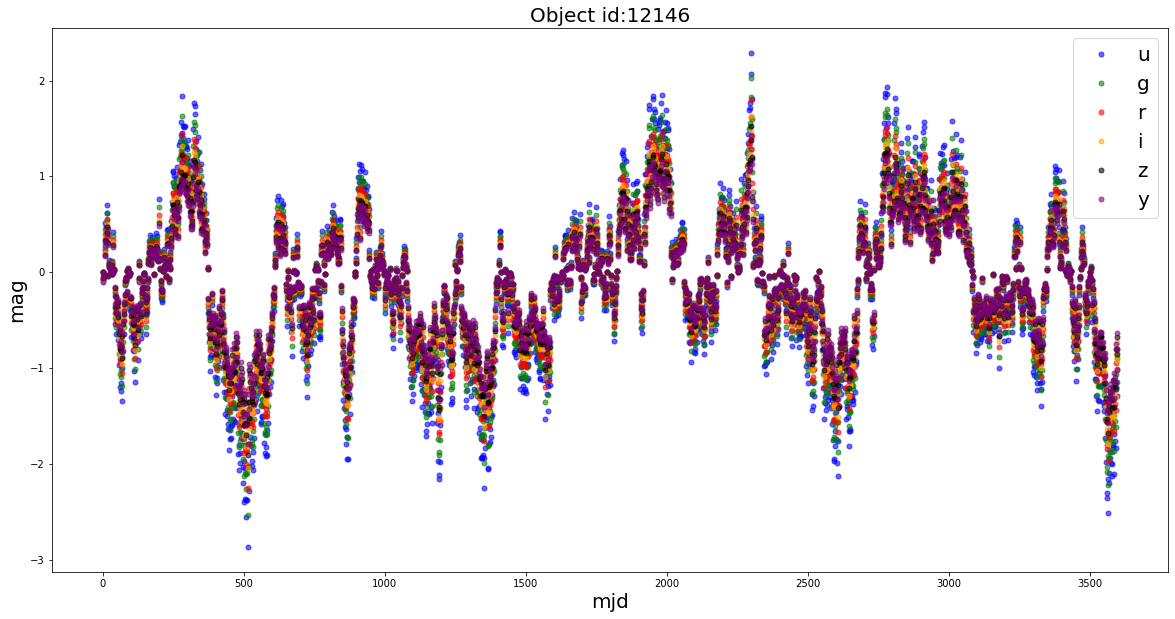

In [10]:

plt.figure(figsize = (20,10))
plt.errorbar(expmjd, result_u, alpha = 0.6,fmt='o',color='blue',elinewidth=2,capsize=3,ms=5,label = 'u')
plt.errorbar(expmjd, result_g, alpha = 0.6,fmt='o',ecolor='green',color='green',elinewidth=2,capsize=3,ms=5,label = 'g')
plt.errorbar(expmjd, result_r, alpha = 0.6,fmt='o',ecolor='r',color='r',elinewidth=2,capsize=3,ms=5,label = 'r')
plt.errorbar(expmjd, result_i, alpha = 0.6,fmt='o',ecolor='orange',color='orange',elinewidth=2,capsize=3,ms=5,label = 'i')
plt.errorbar(expmjd, result_z, alpha = 0.6,fmt='o',ecolor='black',color='black',elinewidth=2,capsize=3,ms=5,label = 'z')
plt.errorbar(expmjd, result_y, alpha = 0.6,fmt='o',ecolor='purple',color='purple',elinewidth=2,capsize=3,ms=5,label = 'y')
plt.legend(fontsize = 20)
plt.title('Object id:' + object_id, fontsize = 20)
plt.xlabel('mjd',fontsize = 20 )
plt.ylabel('mag', fontsize = 20)
plt.show()

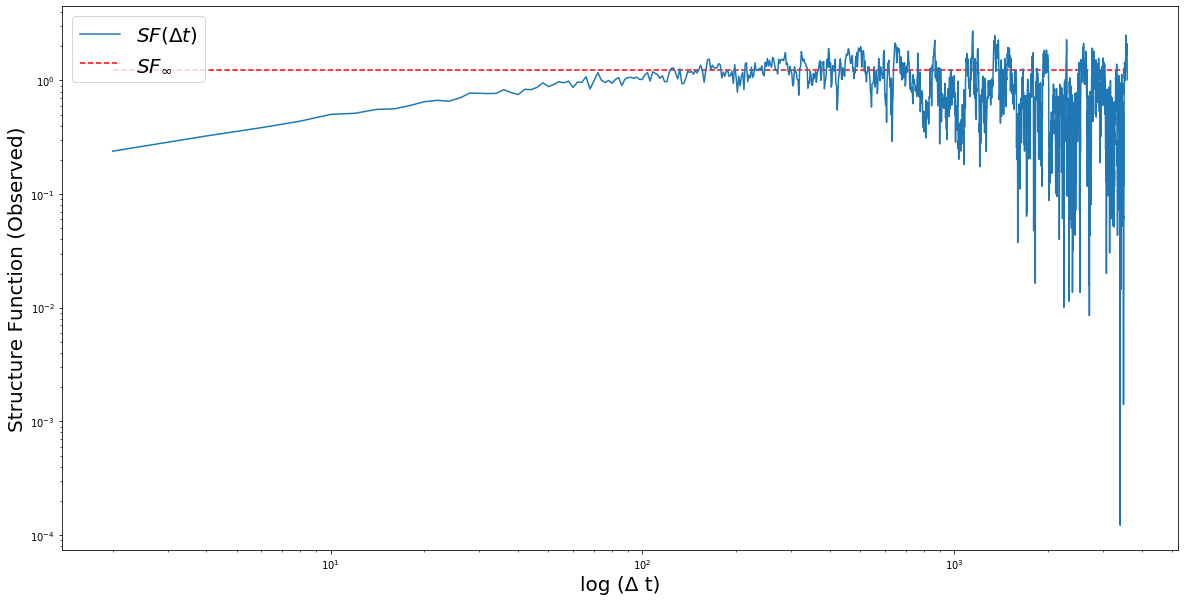

In [11]:
obs_SF_list, delta_list = calculate_obs_SF(expmjd, result_u)

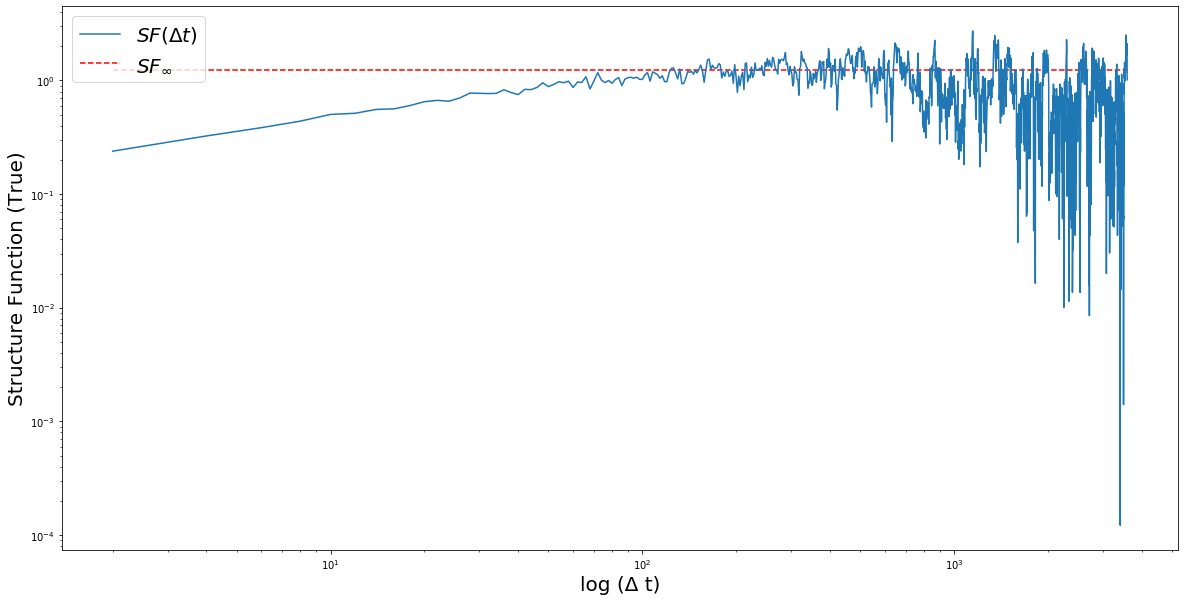

In [12]:
calculate_true_SF(obs_SF_list, delta_list, result_u)

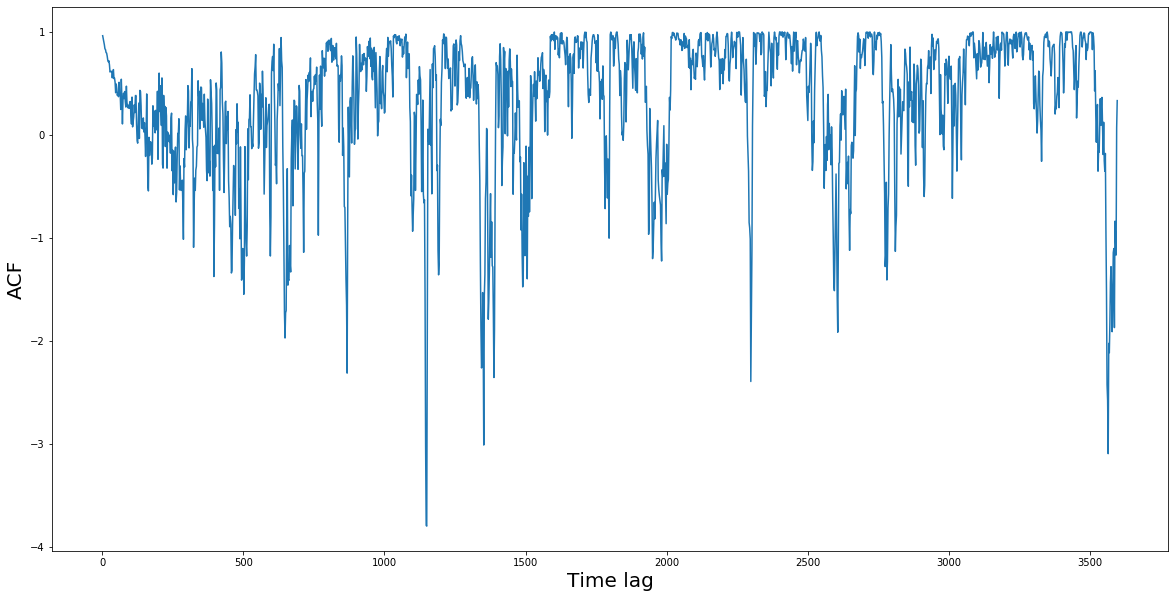

In [13]:
caculate_ACF(obs_SF_list, delta_list,result_u)

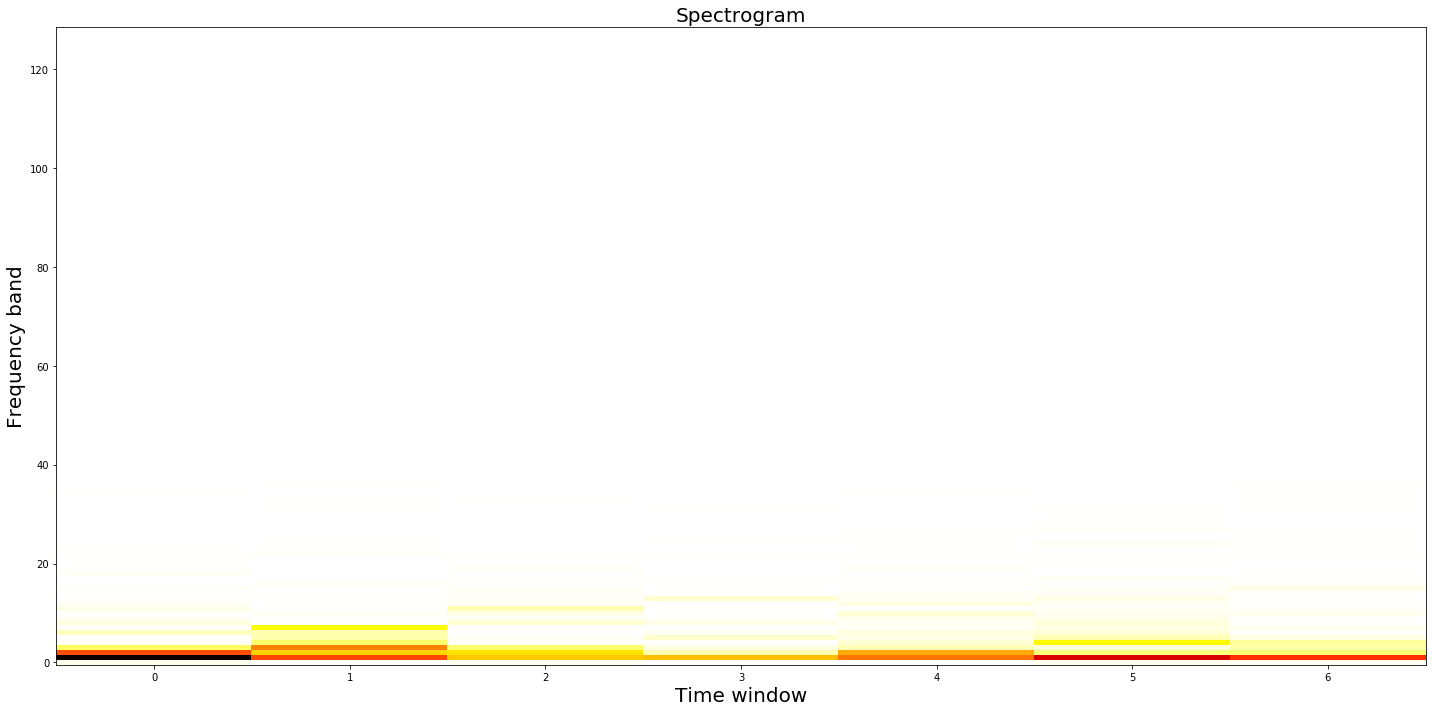

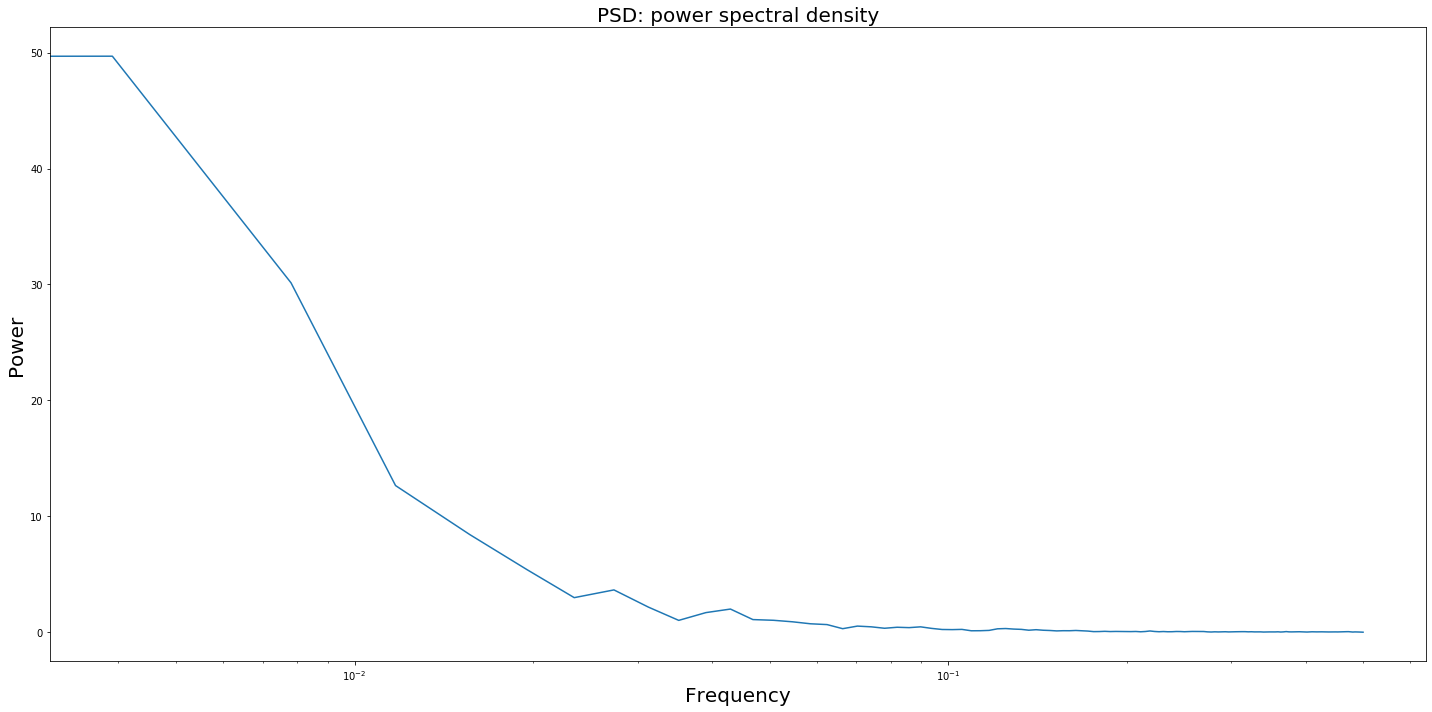

In [14]:
plot_PSD(result_u)

### Use DRW kernel test the simulation

In [15]:
import autograd.numpy as np
import celerite
from celerite import terms
from celerite import GP
from scipy.optimize import minimize

class DRW_kernel(terms.Term):
    # build a Damped Random Walk kernel, a means the standard variance, c means the characteristic timescale
    
	parameter_names = ("log_a", "log_c")
	
	def get_real_coefficients(self, params):
		log_a, log_c = params
        
		return np.exp(log_a)**2, 1.0/np.exp(log_c)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

def GP_lc(mjd, band, band_err, sigma_in, tau_in):
    
    print("True SF infinte: ", sigma_in*np.sqrt(2))
    print("True Tau: ", tau_in)
    kernel = DRW_kernel(log_a = np.log(sigma_in), log_c = np.log(tau_in))
    gp = GP(kernel, mean=np.mean(band))
    gp.compute(mjd, band_err)  

    print("Initial log likelihood: {0}".format(gp.log_likelihood(band)))  
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
    print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
    print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))
    
    #find the maximum likelihood parameters for this model
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(band, gp))
    gp.set_parameter_vector(soln.x)
    
    print(soln)
    
    a_out = gp.get_parameter_dict()['kernel:log_a']
    c_out = gp.get_parameter_dict()['kernel:log_c']
    SF_inft = np.sqrt(2)*np.exp(a_out)
    tau_out = np.exp(c_out)
    
    print("Estimated SF infinte: ", SF_inft)
    print("Estimated Tau: ", tau_out)
    return gp

def predict_lc(gp, mjd, band_name, band, band_err):
    continuous_mjd = np.linspace(min(mjd),max(mjd),2000)
    pred_mean, pred_var = gp.predict(band, continuous_mjd, return_var=True)
    pred_std = np.sqrt(pred_var)
   
    #plot the predicted light curve
    color = "#ff7f0e"
    plt.figure(figsize = (20,10))
    plt.errorbar(mjd, band, yerr=band_err, fmt=".k", capsize=0)
    plt.plot(continuous_mjd, pred_mean, color=color)
    plt.fill_between(continuous_mjd, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none")
    plt.xlabel("mjd (days)",fontsize=20)
    plt.ylabel("flux",fontsize=20)
    plt.title(band_name+' band maximum likelihood prediction',fontsize=20)
    plt.show()
    return pred_mean, pred_std

True SF infinte:  1.411
True Tau:  48.9122
Initial log likelihood: 36.774910796783615
parameter_dict:
OrderedDict([('kernel:log_a', -0.0022749174092957128), ('kernel:log_c', 3.8900268541162393)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-2.27491741e-03  3.89002685e+00]

parameter_bounds:
[(None, None), (None, None)]

      fun: -40.263508875581465
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00466116,  0.00118234])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 13
   status: 0
  success: True
        x: array([-0.13098174,  3.55537805])
Estimated SF infinte:  1.2405959298463807
Estimated Tau:  35.00104972924391


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


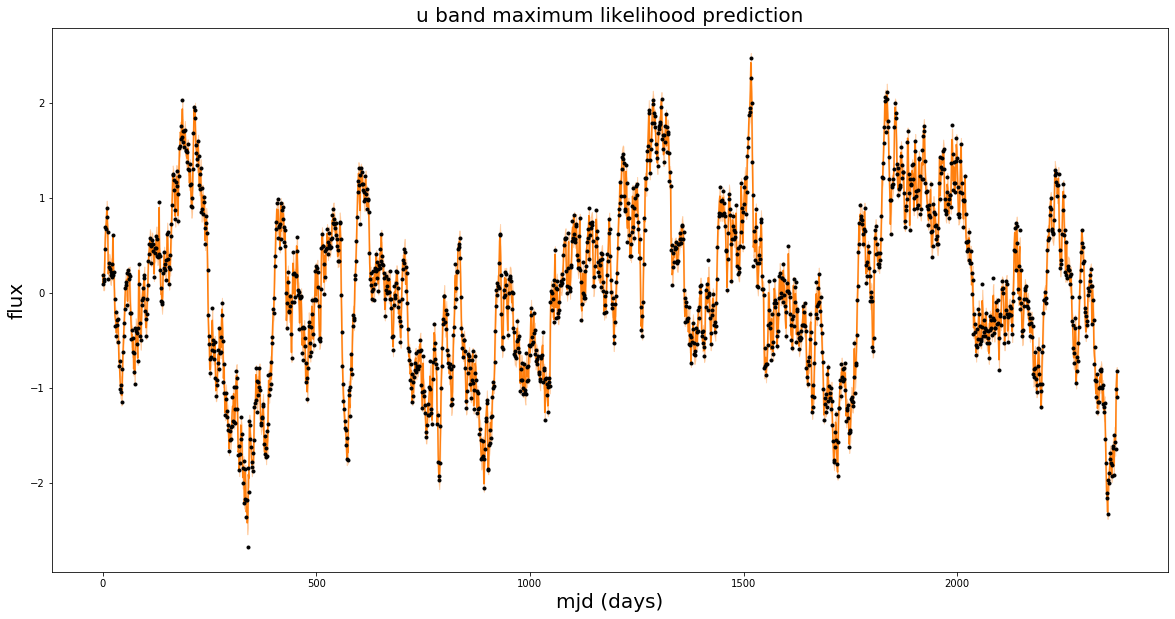

True SF infinte:  1.248
True Tau:  48.9122
Initial log likelihood: 257.73643605895404
parameter_dict:
OrderedDict([('kernel:log_a', -0.12503132033273676), ('kernel:log_c', 3.8900268541162393)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-0.12503132  3.89002685]

parameter_bounds:
[(None, None), (None, None)]

      fun: -261.22503412681044
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00970886, -0.00077307])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 11
   status: 0
  success: True
        x: array([-0.25381943,  3.55521148])
Estimated SF infinte:  1.0971919666608636
Estimated Tau:  34.9952200889026


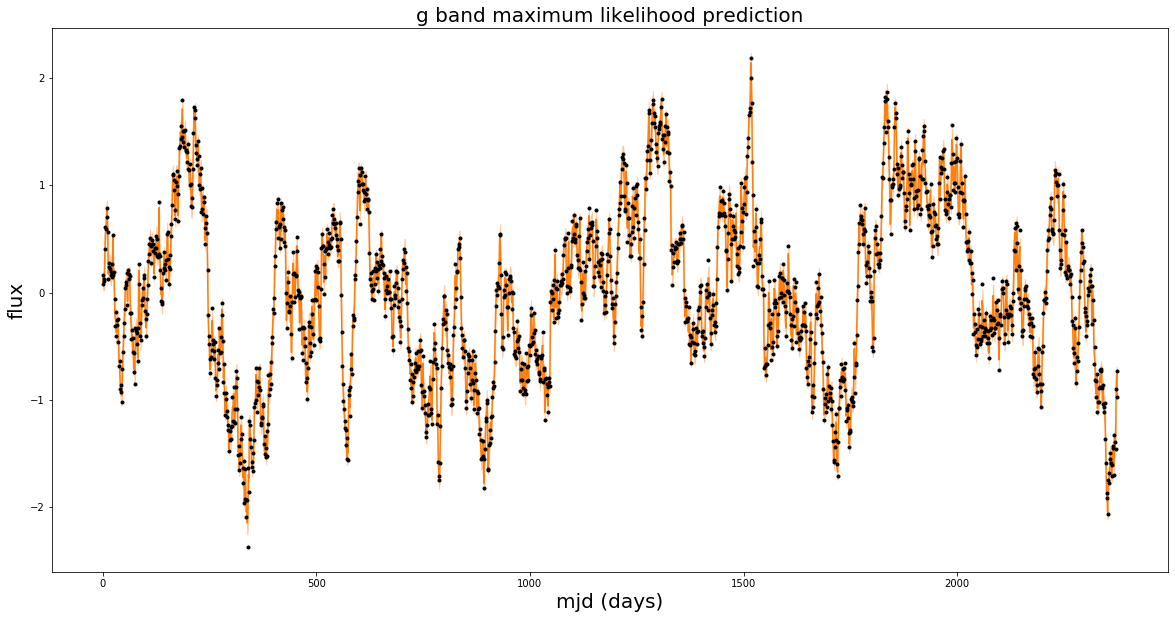

True SF infinte:  1.107
True Tau:  48.9122
Initial log likelihood: 473.5359452563971
parameter_dict:
OrderedDict([('kernel:log_a', -0.24491993655347286), ('kernel:log_c', 3.8900268541162393)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-0.24491994  3.89002685]

parameter_bounds:
[(None, None), (None, None)]

      fun: -477.0245434321382
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0050477 ,  0.00582077])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 11
   status: 0
  success: True
        x: array([-0.37365741,  3.55531935])
Estimated SF infinte:  0.9732796580471813
Estimated Tau:  34.99899509168359


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


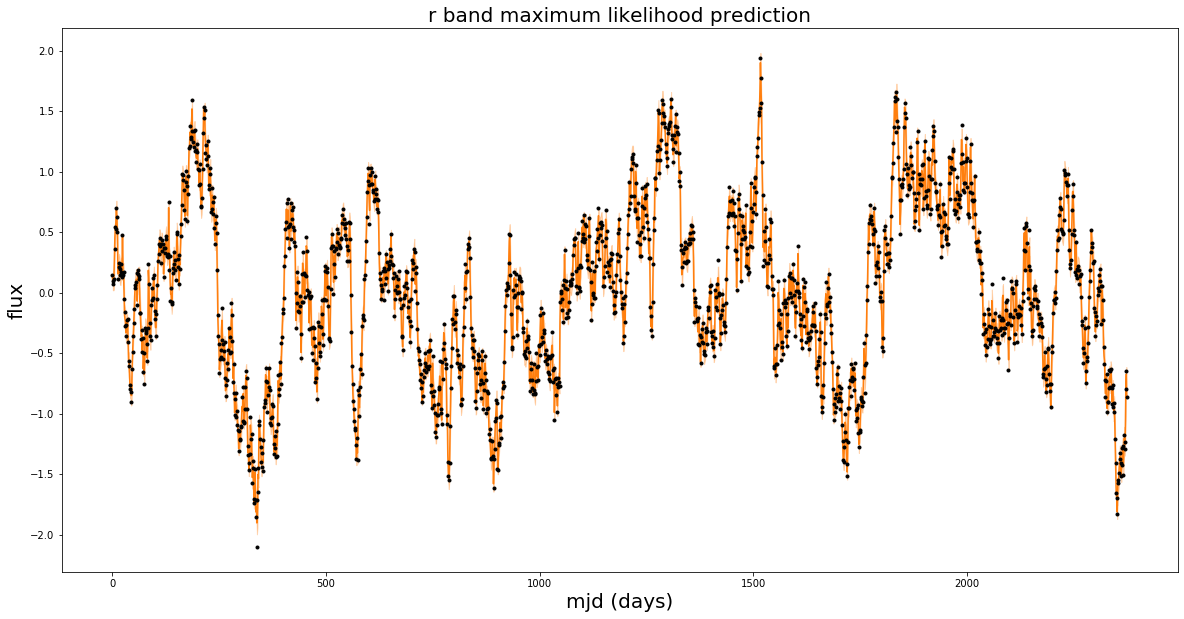

True SF infinte:  1.006
True Tau:  48.9122
Initial log likelihood: 645.7447929444506
parameter_dict:
OrderedDict([('kernel:log_a', -0.3405915186024252), ('kernel:log_c', 3.8900268541162393)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-0.34059152  3.89002685]

parameter_bounds:
[(None, None), (None, None)]

      fun: -649.2333911151591
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00313776, 0.00104592])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 12
   status: 0
  success: True
        x: array([-0.46935428,  3.5552635 ])
Estimated SF infinte:  0.8844576112406668
Estimated Tau:  34.99704044387574


/Users/sherrysheng/opt/anaconda3/envs/venv/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


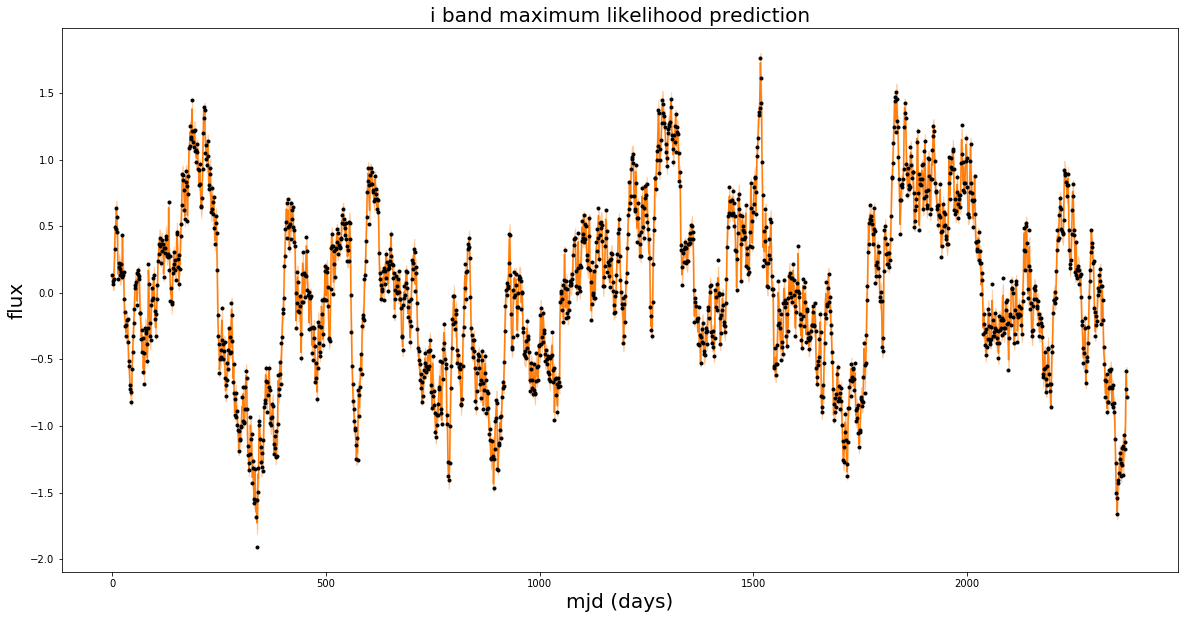

True SF infinte:  0.939
True Tau:  48.9122
Initial log likelihood: 769.8041615569468
parameter_dict:
OrderedDict([('kernel:log_a', -0.40951339005384685), ('kernel:log_c', 3.8900268541162393)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-0.40951339  3.89002685]

parameter_bounds:
[(None, None), (None, None)]

      fun: -773.2927595080396
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00804903, 0.00873115])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 11
   status: 0
  success: True
        x: array([-0.53820262,  3.55541663])
Estimated SF infinte:  0.8256130875559511
Estimated Tau:  35.00239991186025


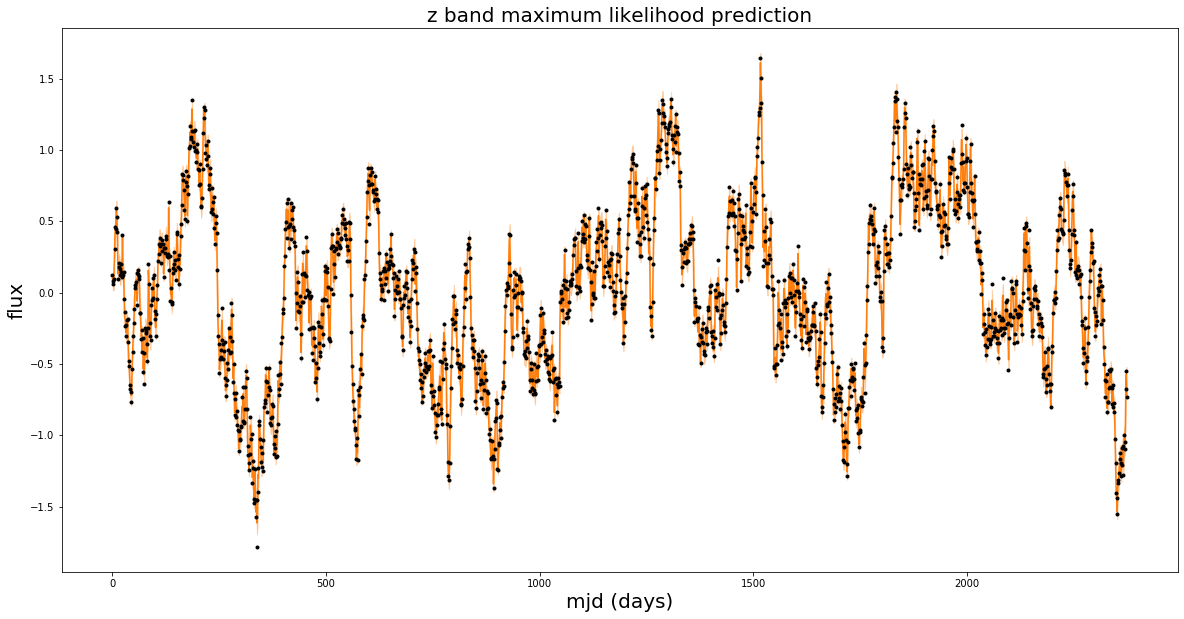

True SF infinte:  0.8800000000000001
True Tau:  48.9122
Initial log likelihood: 886.6125906819561
parameter_dict:
OrderedDict([('kernel:log_a', -0.47440696178985753), ('kernel:log_c', 3.8900268541162393)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-0.47440696  3.89002685]

parameter_bounds:
[(None, None), (None, None)]

      fun: -890.1011887017548
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00231921, -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 132
      nit: 12
   status: 0
  success: True
        x: array([-0.6032031 ,  3.55519727])
Estimated SF infinte:  0.7736547952835207
Estimated Tau:  34.99472262292174


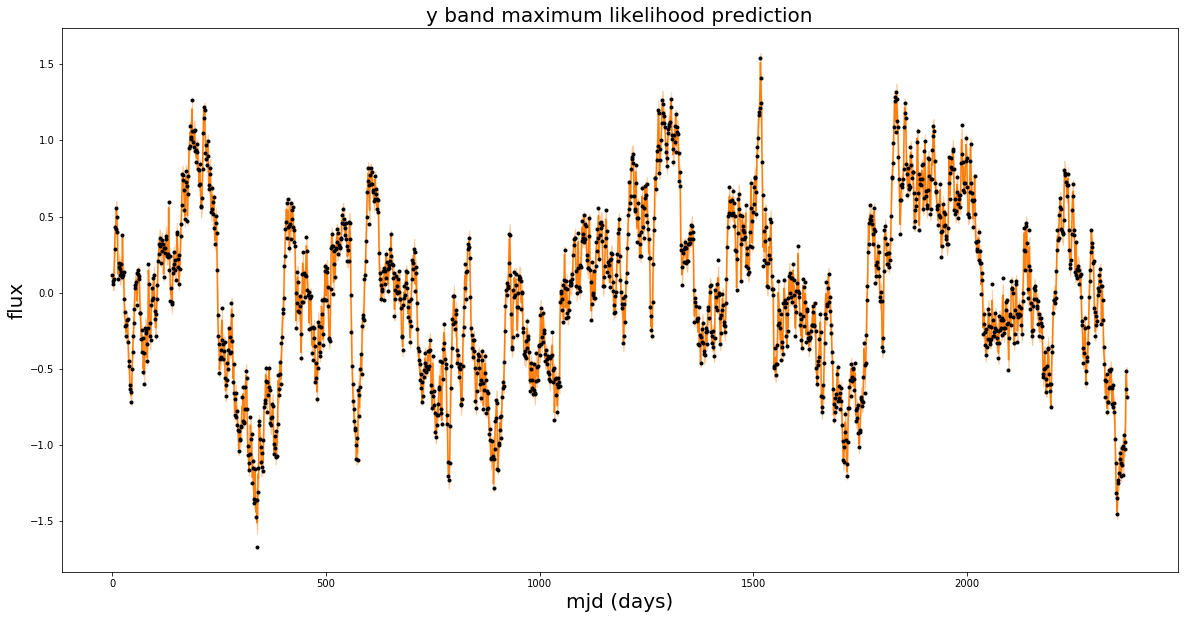

In [16]:
# target = {'mjd':expmjd,'u':mag_u, 'g':mag_g,'r':mag_r,'i':mag_i,'z':mag_z,'y':mag_y }
target = {'mjd':expmjd,'u':result_u, 'g':result_g,'r':result_r,'i':result_i,'z':result_z,'y':result_y }
bands = ['u','g','r','i','z','y']

# print(tau_in)
# print(sigma_in, tau)
for i in bands:
    err = np.zeros(len(target['mjd']))
    sigma_in = SF_dict[i]/np.sqrt(2)
    mean_band = np.mean(target[i])
    target[i] -= mean_band
    gp = GP_lc(target['mjd']/time_dilation, target[i], err, sigma_in, tau)
    predict_lc(gp, target['mjd']/time_dilation, i,target[i],err )
